In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

## config(kernel使うときに変更すべき変数)

In [2]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"


## データ加工部

## CNN(画像＋テーブル)


__version__

__ver1__<br>
train_concat&メタデータ込み：CV:0.974, LB:????<br>
__ver2__<br>
256*256：CV:0.885, LB:0.890<br>
__verSN:1__<br>
metaval:resizeのみ<br>
192_192：OOF: 0.869 Wall time:  1h 33min LB: 0.861<br>
224_224：OOF: 0.883 Wall time:  2h 07min LB: 0.862<br>
256_256：OOF: 0.875 Wall time:  2h 36min LB: 0.882<br>
382_382：OOF: 0.869 Wall time:  5h 10min LB: 0.854<br>
512_512：OOF: 0.848 Wall time: 10h 29min LB: 0.852<br>
__verSN:2__<br>
metaval:metaの組み込み<br>
64_64  ：OOF: 0.856 Wall time: 20min 50s LB: 0.852<br>
256_256：OOF: 0.874 Wall time: 2h 31min 55s LB: 0.885<br>
__verSN:3__<br>
stackingに切り替え<br>
64_64  ：OOF: 0.876 Wall time: 30min 59s    LB: 0.8779<br>
128_128：OOF: 0.881 Wall time: about 50min  LB: 0.8756<br>
192_192：OOF: 0.893 Wall time: 2h 10min 17s LB: 0.8813<br>
224_224：OOF: 0.892 Wall time: 2h 41min 8s  LB: 0.8807<br>
256_256：OOF: 0.897 Wall time: 3h 24min 25s LB: 0.8760<br>
384_384：OOF: 0.872 Wall time: 7h 26min 48s LB: 0.8676<br>
__verSN:4__<br>
tfrecordによるfold + epoch20<br>
64_64  ：OOF: 0.873 Wall time: 38min 15s    LB:0.8856 <br>
96_96  ：OOF: 0.879 Wall time: 54min 34s    LB:0.8719 <br>
128_128：OOF: 0.882 Wall time: 1h 20min 49s LB:0.8929 <br>
160_160：OOF: 0.884 Wall time: 2h 8min 24s  LB:0.8678 <br>
192_192：OOF: 0.885 Wall time: 不明         LB:0.8704 <br>
__verSN:5__<br>
2019データ<br>
64_64  ：OOF: 0.903 Wall time: 30min 37s    LB:0.7135 <br>
128_128：OOF: 0.924 Wall time: 不明         LB:0.7449 <br>
__verSN:6__<br>
train + malignant2019 merge<br>
64_64  ：OOF: 0.821 Wall time: 24min 19s    LB:0.8924 <br>
128_128：OOF: 0.891 Wall time: 1h 12min 48s LB:0.8891 <br>
256_256：OOF: 0.900 Wall time: 4h 19min 32s LB:0.8857 <br>
__verSN:7__<br>
train + malignant2019 merge → BGR2GRAY<br>
64_64  ：OOF: 0.812 Wall time: 27min        LB:0.8396 <br>
128_128：OOF: 0.889 Wall time: 1h 5min 16s  LB:0.8633 <br>
256_256：OOF: 0.897 Wall time: 3h 44min 52s LB:0.8523 <br>
__verSN:8__<br>
pad BGR2GRAY<br>
64_64  ：OOF: 0.948 Wall time: 28min        LB:0.8758 <br>

In [3]:
# At least fixing some random seeds. 
# It is still impossible to make results 100% reproducible when using GPU
warnings.simplefilter('ignore')
torch.manual_seed(47)
np.random.seed(47)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, 
                 transforms = None,  meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description→学習に使わない
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        x = cv2.imread(im_path)
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            #X_data_np = np.array(x)
            #print("transfor前")
            #print(X_data_np.shape)
            #y_data_np = np.array(y)
            x = self.transforms(x)
            
        if self.train:
            y = self.df.loc[index]['target']
            #return (x, meta), y
            #print(y)
            #X_data_np = np.array(x)
            #print("transform後")
            #print(X_data_np.shape)
            #y_data_np = np.array(y)
            #print(y_data_np.shape)
            return (x, meta), y
        else:
            return (x, meta)
            #return x
    
    def __len__(self):
        return len(self.df)
    
    
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 50 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [6]:
train_transform = transforms.Compose([
    #transforms.RandomResizedCrop(size=224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    #transforms.RandomResizedCrop(size=224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [7]:
arch = EfficientNet.from_pretrained('efficientnet-b1')  # Going to use efficientnet-b0 NN architecture
# skf = StratifiedKFold(n_splits=3, random_state=999, shuffle=True)
skf = GroupKFold(n_splits=5)

Loaded pretrained weights for efficientnet-b1


In [8]:
def TableDataPreprocess2020(dt):
    # One-hot encoding of anatom_site_general_challenge feature
    concat = pd.concat([dt[0]['anatom_site_general_challenge'], dt[1]['anatom_site_general_challenge']], ignore_index=True)
    dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
    dt[0] = pd.concat([dt[0], dummies.iloc[:dt[0].shape[0]]], axis=1)
    dt[1] = pd.concat([dt[1], dummies.iloc[dt[0].shape[0]:].reset_index(drop=True)], axis=1)
    for df in dt:
        df['sex'] = df['sex'].map({'male': 1, 'female': 0})
        df['sex'] = df['sex'].fillna(-1)
        df['age_approx'] /= df['age_approx'].max()
        df['age_approx'] = df['age_approx'].fillna(0)
        df['patient_id'] = df['patient_id'].fillna(0)
    return dt

def TableDataPreprocess2019(dt):
    # One-hot encoding of anatom_site_general_challenge feature
    concat = pd.concat([dt[0]['anatom_site_general_challenge'], dt[1]['anatom_site_general_challenge']], ignore_index=True)
    dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
    dt[0] = pd.concat([dt[0], dummies.iloc[:dt[0].shape[0]]], axis=1)
    dt[1] = pd.concat([dt[1], dummies.iloc[dt[0].shape[0]:].reset_index(drop=True)], axis=1)
    for df in dt:
        df['sex'] = df['sex'].map({'male': 1, 'female': 0})
        df['sex'] = df['sex'].fillna(-1)
        df['age_approx'] /= df['age_approx'].max()
        df['age_approx'] = df['age_approx'].fillna(0)
    return dt

In [12]:
def Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord = None):
    
    meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
    meta_features.remove('anatom_site_general_challenge')
    
    #sample_sub_metaval_stacking.csv用Imagename
    ImgNm = train_df[['image_name']]
    
    
    test = MelanomaDataset(df=test_df,
                           imfolder = SIIM_ISIC_Melanoma_Classification + test_folder, 
                           train=False,
                           transforms=test_transform,
                           meta_features=meta_features)
    oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
    
    # We stratify by target value, thus, according to sklearn StratifiedKFold documentation
    # We can fill `X` with zeroes of corresponding length to use it as a placeholder
    # since we only need `y` to stratify the data
    # for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target']), 1):
    #for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target'], groups=tfrecord['tfrecord'].tolist()), 1):
    for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target'], groups=train_df['patient_id'].tolist()), 1):
        print('=' * 20, 'Fold', fold, '=' * 20)
        
        best_val = None  # Best validation score within this fold
        patience = es_patience  # Current patience counter
        arch = EfficientNet.from_pretrained('efficientnet-b1')
        model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
        model = model.to(device)
        
        
        optim = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
        criterion = nn.BCEWithLogitsLoss()
        
        train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True),  
                                imfolder = SIIM_ISIC_Melanoma_Classification + train_folder, 
                                train=True, 
                                transforms=train_transform,
                                meta_features=meta_features)
        val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True),
                              imfolder = SIIM_ISIC_Melanoma_Classification + train_folder,
                              train=True,
                              transforms=test_transform,
                              meta_features=meta_features)
    
        train_loader = DataLoader(dataset=train, batch_size=bat_size[0], shuffle=True, num_workers=2)
        val_loader = DataLoader(dataset=val, batch_size=bat_size[1], shuffle=False, num_workers=2)
        test_loader = DataLoader(dataset=test, batch_size=bat_size[2], shuffle=False, num_workers=2)
        
        del train, val
        gc.collect()
        
        for epoch in range(epochs):
            start_time = time.time()
            correct = 0
            epoch_loss = 0
            model.train()
            
            for x, y in train_loader:
                x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
                x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
                y = torch.tensor(y, device=device, dtype=torch.float32)
                
                
                optim.zero_grad()
                z = model(x)
                loss = criterion(z, y.unsqueeze(1))
                loss.backward()
                optim.step()
                pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
                correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
                epoch_loss += loss.item()
    
                
            train_acc = correct / len(train_idx)
    
            model.eval()  # switch model to the evaluation mode
            val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
            with torch.no_grad():  # Do not calculate gradient since we are only predicting
                # Predicting on validation set
                for j, (x_val, y_val) in enumerate(val_loader):
                    x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                    x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                    y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                    z_val = model(x_val)
                    val_pred = torch.sigmoid(z_val)
                    val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
                val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
                val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
                
                print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
                epoch + 1, 
                epoch_loss, 
                train_acc, 
                val_acc, 
                val_roc, 
                str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
                
                scheduler.step(val_roc)
                # During the first iteration (first epoch) best validation is set to None
                if not best_val:
                    best_val = val_roc  # So any validation roc_auc we have is the best one for now
                    torch.save(model, model_path)  # Saving the model
                    continue
                    
                if val_roc >= best_val:
                    best_val = val_roc
                    patience = es_patience  # Resetting patience since we have new best validation accuracy
                    torch.save(model, model_path)  # Saving current best model
                else:
                    patience -= 1
                    if patience == 0:
                        print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                        break
        
        del train_loader, x, y
        gc.collect()
        
        model = torch.load(model_path)  # Loading best model of this fold
        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        test_preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test set
        with torch.no_grad():
            # Predicting on validation set once again to obtain data for OOF
            for _ in range(TTA):
                for j, (x_val, y_val) in enumerate(val_loader):
                    x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                    x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                    y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                    z_val = model(x_val)
                    val_pred = torch.sigmoid(z_val)
                    val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
            val_preds /= TTA
            oof[val_idx] = val_preds.cpu()
            del val_loader, x_val, y_val
            gc.collect()
            
            # Predicting on test set
            for _ in range(TTA):
                for i, x_test in enumerate(test_loader):
                    x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                    x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                    z_test = model(x_test)
                    z_test = torch.sigmoid(z_test)
                    test_preds[i*x_test[0].shape[0]:i*x_test[0].shape[0] + x_test[0].shape[0]] += z_test
            test_preds /= TTA
            del test_loader, x_test, z_test
            gc.collect()
        
    test_preds /= skf.n_splits
    
    print('OOF: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))
    
    return test_preds, oof, ImgNm

In [10]:
def initData2020(Pre):
    #train(train+2019malig)
    train_malig = pd.read_csv(SIIM_ISIC_Melanoma_Classification + "train_malig_2.csv")
    train_malig = train_malig[train_malig.tfrecord != -1]
    train_malig = train_malig.drop(['diagnosis', 'benign_malignant', 'width', 'height', 'source', 'ext'], axis=1)
    train_malig = train_malig.reset_index(drop=True)
    tfrecord_malig = train_malig.loc[:,['tfrecord']]
    tfrecord_malig = tfrecord_malig-15
    
    
    train_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
    train_df = train_df.drop(['diagnosis','benign_malignant'], axis=1)
    train_df = train_df[train_df.tfrecord != -1]
    train_df = train_df.drop(['width','height','patient_code'], axis=1)
    train_df = train_df.reset_index(drop=True)
    tfrecord = train_df.loc[:,['tfrecord']]
    
    #concate(train+2019malig)
    train_df = pd.concat([train_df, train_malig], axis=0)
    train_df = train_df.reset_index(drop=True)
    
    #padding (malignantOnly)
    train_pad = train_df[train_df.target == 1]
    train_pad = train_pad.reset_index(drop=True)
    train_pad[['image_name']] = Pre + '_' + train_pad[['image_name']]
    tfrecord_pad = train_pad.loc[:,['tfrecord']]
    
    #concate(train+2019malig) + BGR2GRAY(malignantOnly)
    train_df = pd.concat([train_df, train_pad], axis=0)
    train_df = train_df.drop(['tfrecord'], axis=1)
    train_df = train_df.reset_index(drop=True)
    tfrecord = pd.concat([tfrecord, tfrecord_malig, tfrecord_pad], axis=0)
    tfrecord = tfrecord.reset_index(drop=True)
    
    
    #test
    test_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
    
    return train_df, test_df, tfrecord

def initData2019():
    train_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train_2019year.csv')
    train_df = train_df.drop(['diagnosis','benign_malignant'], axis=1)
    train_df = train_df[train_df.tfrecord != -1]
    train_df = train_df.drop(['width','height'], axis=1) 

    train_df = train_df.reset_index(drop=True)
    tfrecord = train_df.loc[:,['tfrecord']]
    train_df = train_df.drop(['tfrecord'], axis=1)
    
    test_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
    
    train_df = train_df.drop(['patient_id'], axis=1)
    test_df = test_df.drop(['patient_id'], axis=1)
    
    return train_df, test_df, tfrecord

In [ ]:
%%time
#trainRoman
model_name = "train_roman"
train_folder = "jpeg/" + model_name
test_folder = "pad_jpg/test/" + "256_256"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [32, 16, 16] #train, val, test

#データ整形
#train_df, test_df, tfrecord = initData2020()
train_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train_roman.csv')
test_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 105.343 | Train acc: 0.968 | Val acc: 0.939 | Val roc_auc: 0.958 | Training time: 0:04:31
Epoch 002: | Loss: 86.838 | Train acc: 0.974 | Val acc: 0.959 | Val roc_auc: 0.971 | Training time: 0:04:31
Epoch 003: | Loss: 79.692 | Train acc: 0.976 | Val acc: 0.959 | Val roc_auc: 0.971 | Training time: 0:04:31
Epoch 004: | Loss: 76.978 | Train acc: 0.976 | Val acc: 0.949 | Val roc_auc: 0.968 | Training time: 0:04:32
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch 005: | Loss: 60.895 | Train acc: 0.981 | Val acc: 0.961 | Val roc_auc: 0.977 | Training time: 0:04:32
Epoch 006: | Loss: 56.753 | Train acc: 0.982 | Val acc: 0.964 | Val roc_auc: 0.975 | Training time: 0:04:32


==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 26.877 | Train acc: 0.964 | Val acc: 0.974 | Val roc_auc: 0.925 | Training time: 0:00:28
Epoch 002: | Loss: 18.488 | Train acc: 0.976 | Val acc: 0.978 | Val roc_auc: 0.933 | Training time: 0:00:28
Epoch 003: | Loss: 16.740 | Train acc: 0.978 | Val acc: 0.976 | Val roc_auc: 0.937 | Training time: 0:00:28
Epoch 004: | Loss: 16.789 | Train acc: 0.979 | Val acc: 0.975 | Val roc_auc: 0.930 | Training time: 0:00:28
Epoch 005: | Loss: 16.104 | Train acc: 0.979 | Val acc: 0.978 | Val roc_auc: 0.939 | Training time: 0:00:29
Epoch 006: | Loss: 14.957 | Train acc: 0.980 | Val acc: 0.978 | Val roc_auc: 0.933 | Training time: 0:00:29
Epoch 007: | Loss: 15.052 | Train acc: 0.980 | Val acc: 0.977 | Val roc_auc: 0.942 | Training time: 0:00:29
Epoch 008: | Loss: 14.803 | Train acc: 0.980 | Val acc: 0.977 | Val roc_auc: 0.939 | Training time: 0:00:30
Epoch 009: | Loss: 13.653 | Train acc: 0.

100%|██████████| 281k/281k [00:02<00:00, 109kB/s]  


CPU times: user 25min 49s, sys: 4min 47s, total: 30min 36s
Wall time: 32min 52s


Successfully submitted to SIIM-ISIC Melanoma Classification

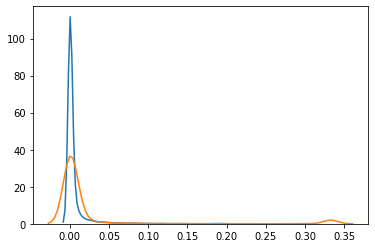

In [11]:
%%time
#PADDING_64_64_merge_BGR2GRAY(malignantOnly)
model_name = "PADDING_64_64_merge_BGR2GRAY(malignantOnly)"
train_folder = "pad_jpg/train_pad/" + model_name
test_folder = "pad_jpg/test/" + "64_64"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [127, 32, 32] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020()
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

In [11]:
%%time
#PADDING_128_128_merge_BGR2GRAY(malignantOnly)
model_name = "PADDING_128_128_merge_BGR2GRAY(malignantOnly)"
train_folder = "pad_jpg/train_pad/" + model_name
test_folder = "pad_jpg/test/" + "128_128"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [64, 32, 32] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020()
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

TypeError: initData2020() missing 1 required positional argument: 'Pre'

In [16]:
%%time
#PADDING_256_256_merge_BGR2GRAY(malignantOnly)
model_name = "PADDING_256_256_merge_BGR2GRAY(malignantOnly)"
train_folder = "pad_jpg/train_pad/" + model_name
test_folder = "pad_jpg/test/" + "256_256"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [32, 16, 16] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020()
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

TypeError: Exec() takes from 7 to 8 positional arguments but 9 were given

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 25.672 | Train acc: 0.966 | Val acc: 0.972 | Val roc_auc: 0.928 | Training time: 0:00:29
Epoch 002: | Loss: 18.408 | Train acc: 0.977 | Val acc: 0.976 | Val roc_auc: 0.938 | Training time: 0:00:29
Epoch 003: | Loss: 17.589 | Train acc: 0.977 | Val acc: 0.972 | Val roc_auc: 0.932 | Training time: 0:00:29
Epoch 004: | Loss: 16.706 | Train acc: 0.979 | Val acc: 0.978 | Val roc_auc: 0.934 | Training time: 0:00:28
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch 005: | Loss: 14.138 | Train acc: 0.981 | Val acc: 0.978 | Val roc_auc: 0.943 | Training time: 0:00:29
Epoch 006: | Loss: 13.286 | Train acc: 0.982 | Val acc: 0.978 | Val roc_auc: 0.944 | Training time: 0:00:29
Epoch 007: | Loss: 12.605 | Train acc: 0.982 | Val acc: 0.978 | Val roc_auc: 0.946 | Training time: 0:00:29
Epoch 008: | Loss: 12.364 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.945 | Tr

OOF: 0.948


100%|██████████| 282k/282k [00:05<00:00, 56.4kB/s]


CPU times: user 26min 17s, sys: 4min 46s, total: 31min 3s
Wall time: 33min 23s


Successfully submitted to SIIM-ISIC Melanoma Classification

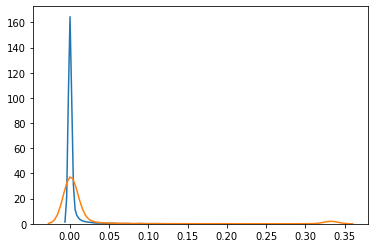

In [12]:
%%time
model_name = "PADDING_64_64_merge_ROTATE_90(malignantOnly)"
train_folder = "pad_jpg/train_pad/" + model_name
test_folder = "pad_jpg/test/" + "64_64"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [127, 32, 32] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020("ROTATE_90")
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 44.032 | Train acc: 0.972 | Val acc: 0.962 | Val roc_auc: 0.930 | Training time: 0:01:15
Epoch 002: | Loss: 33.780 | Train acc: 0.978 | Val acc: 0.975 | Val roc_auc: 0.944 | Training time: 0:01:14
Epoch 003: | Loss: 32.439 | Train acc: 0.978 | Val acc: 0.980 | Val roc_auc: 0.944 | Training time: 0:01:14
Epoch 004: | Loss: 29.797 | Train acc: 0.980 | Val acc: 0.976 | Val roc_auc: 0.947 | Training time: 0:01:14
Epoch 005: | Loss: 28.804 | Train acc: 0.981 | Val acc: 0.978 | Val roc_auc: 0.943 | Training time: 0:01:15
Epoch 006: | Loss: 28.759 | Train acc: 0.980 | Val acc: 0.978 | Val roc_auc: 0.944 | Training time: 0:01:15
Epoch     6: reducing learning rate of group 0 to 2.0000e-04.
Epoch 007: | Loss: 23.448 | Train acc: 0.984 | Val acc: 0.979 | Val roc_auc: 0.949 | Training time: 0:01:14
Epoch 008: | Loss: 20.699 | Train acc: 0.984 | Val acc: 0.978 | Val roc_auc: 0.950 | Tr

100%|██████████| 280k/280k [00:03<00:00, 89.1kB/s]


CPU times: user 54min 35s, sys: 15min 37s, total: 1h 10min 12s
Wall time: 1h 13min 50s


Successfully submitted to SIIM-ISIC Melanoma Classification

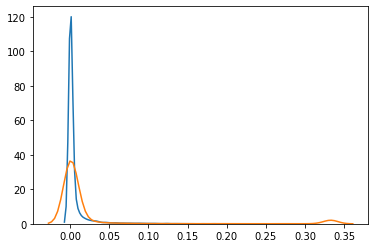

In [13]:
%%time
model_name = "PADDING_128_128_merge_ROTATE_90(malignantOnly)"
train_folder = "pad_jpg/train_pad/" + model_name
test_folder = "pad_jpg/test/" + "128_128"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [65, 32, 32] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020("ROTATE_90")
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 88.895 | Train acc: 0.972 | Val acc: 0.969 | Val roc_auc: 0.940 | Training time: 0:04:10
Epoch 002: | Loss: 70.968 | Train acc: 0.977 | Val acc: 0.976 | Val roc_auc: 0.942 | Training time: 0:04:06
Epoch 003: | Loss: 69.316 | Train acc: 0.979 | Val acc: 0.980 | Val roc_auc: 0.940 | Training time: 0:04:07
Epoch 004: | Loss: 66.868 | Train acc: 0.979 | Val acc: 0.978 | Val roc_auc: 0.939 | Training time: 0:04:06
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch 005: | Loss: 54.191 | Train acc: 0.982 | Val acc: 0.980 | Val roc_auc: 0.946 | Training time: 0:04:07
Epoch 006: | Loss: 50.400 | Train acc: 0.983 | Val acc: 0.980 | Val roc_auc: 0.949 | Training time: 0:04:07
Epoch 007: | Loss: 48.606 | Train acc: 0.983 | Val acc: 0.980 | Val roc_auc: 0.952 | Training time: 0:04:07
Epoch 008: | Loss: 46.038 | Train acc: 0.983 | Val acc: 0.980 | Val roc_auc: 0.953 | Tr

OOF: 0.960


100%|██████████| 278k/278k [00:05<00:00, 56.7kB/s]


CPU times: user 3h 21min 41s, sys: 1h 13min 58s, total: 4h 35min 39s
Wall time: 4h 35min 39s


Successfully submitted to SIIM-ISIC Melanoma Classification

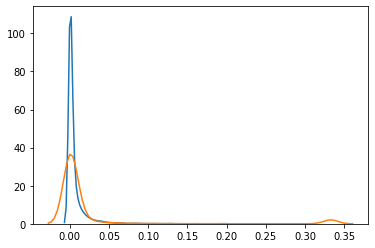

In [14]:
%%time
model_name = "PADDING_256_256_merge_ROTATE_90(malignantOnly)"
train_folder = "pad_jpg/train_pad/" + model_name
test_folder = "pad_jpg/test/" + "256_256"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [32, 16, 16] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020("ROTATE_90")
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

In [15]:
%%time
model_name = "PADDING_64_64_merge_ROTATE_225(malignantOnly)"
train_folder = "pad_jpg/train_pad/" + model_name
test_folder = "pad_jpg/test/" + "64_64"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [127, 32, 32] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020("ROTATE_225")
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [3, 64, 64] at entry 0 and [3, 91, 91] at entry 44


In [16]:
%%time
model_name = "PADDING_128_128_merge_ROTATE_225(malignantOnly)"
train_folder = "pad_jpg/train_pad/" + model_name
test_folder = "pad_jpg/test/" + "128_128"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [65, 32, 32] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020("ROTATE_225")
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [3, 128, 128] at entry 0 and [3, 181, 181] at entry 6


In [17]:
%%time
model_name = "PADDING_256_256_merge_ROTATE_225(malignantOnly)"
train_folder = "pad_jpg/train_pad/" + model_name
test_folder = "pad_jpg/test/" + "256_256"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [32, 16, 16] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020("ROTATE_225")
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/tidal/anaconda3/envs/Melanoma_Classification/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [3, 256, 256] at entry 0 and [3, 362, 362] at entry 5


==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 43.927 | Train acc: 0.971 | Val acc: 0.978 | Val roc_auc: 0.942 | Training time: 0:01:15
Epoch 002: | Loss: 34.554 | Train acc: 0.978 | Val acc: 0.978 | Val roc_auc: 0.943 | Training time: 0:01:15
Epoch 003: | Loss: 32.255 | Train acc: 0.979 | Val acc: 0.974 | Val roc_auc: 0.942 | Training time: 0:01:15
Epoch 004: | Loss: 31.940 | Train acc: 0.979 | Val acc: 0.976 | Val roc_auc: 0.941 | Training time: 0:01:15
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch 005: | Loss: 26.005 | Train acc: 0.982 | Val acc: 0.980 | Val roc_auc: 0.951 | Training time: 0:01:15
Epoch 006: | Loss: 23.328 | Train acc: 0.983 | Val acc: 0.980 | Val roc_auc: 0.954 | Training time: 0:01:15
Epoch 007: | Loss: 21.292 | Train acc: 0.985 | Val acc: 0.980 | Val roc_auc: 0.950 | Training time: 0:01:15
Epoch 008: | Loss: 19.646 | Train acc: 0.986 | Val acc: 0.979 | Val roc_auc: 0.950 | Tr

100%|██████████| 281k/281k [00:03<00:00, 81.8kB/s] 


CPU times: user 51min 39s, sys: 14min 41s, total: 1h 6min 20s
Wall time: 1h 9min 39s


Successfully submitted to SIIM-ISIC Melanoma Classification

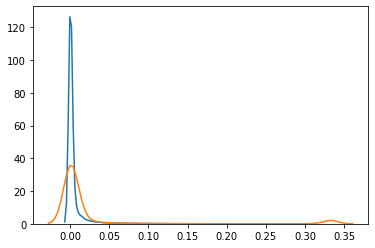

In [18]:
%%time
model_name = "PADDING_128_128_merge_BGR2GRAY(malignantOnly)"
train_folder = "pad_jpg/train_pad/" + model_name
test_folder = "pad_jpg/test/" + "128_128"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [65, 32, 32] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020("GR2GRAY")
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 88.475 | Train acc: 0.972 | Val acc: 0.978 | Val roc_auc: 0.936 | Training time: 0:04:07
Epoch 002: | Loss: 74.465 | Train acc: 0.977 | Val acc: 0.980 | Val roc_auc: 0.937 | Training time: 0:04:06
Epoch 003: | Loss: 66.486 | Train acc: 0.979 | Val acc: 0.980 | Val roc_auc: 0.945 | Training time: 0:04:06
Epoch 004: | Loss: 66.889 | Train acc: 0.979 | Val acc: 0.975 | Val roc_auc: 0.938 | Training time: 0:04:06
Epoch 005: | Loss: 63.380 | Train acc: 0.980 | Val acc: 0.980 | Val roc_auc: 0.936 | Training time: 0:04:06
Epoch     5: reducing learning rate of group 0 to 2.0000e-04.
Epoch 006: | Loss: 52.995 | Train acc: 0.982 | Val acc: 0.980 | Val roc_auc: 0.950 | Training time: 0:04:06
Epoch 007: | Loss: 49.486 | Train acc: 0.983 | Val acc: 0.980 | Val roc_auc: 0.951 | Training time: 0:04:06
Epoch 008: | Loss: 46.823 | Train acc: 0.984 | Val acc: 0.979 | Val roc_auc: 0.953 | Tr

Epoch 015: | Loss: 26.306 | Train acc: 0.989 | Val acc: 0.977 | Val roc_auc: 0.961 | Training time: 0:04:07
Early stopping. Best Val roc_auc: 0.965
OOF: 0.960


100%|██████████| 282k/282k [00:03<00:00, 87.7kB/s] 


CPU times: user 3h 21min 43s, sys: 1h 15min 27s, total: 4h 37min 11s
Wall time: 4h 37min 32s


Successfully submitted to SIIM-ISIC Melanoma Classification

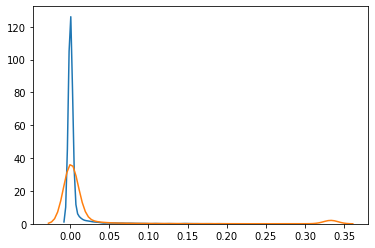

In [11]:
%%time
model_name = "PADDING_256_256_merge_BGR2GRAY(malignantOnly)"
train_folder = "pad_jpg/train_pad/" + model_name
test_folder = "pad_jpg/test/" + "256_256"
epochs = 20  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [32, 16, 16] #train, val, test

#データ整形
train_df, test_df, tfrecord = initData2020("GR2GRAY")
dt = [train_df, test_df]
[train_df, test_df] = TableDataPreprocess2020(dt)


#実行
test_preds, metaval_preds, metaval_ID = Exec(epochs, model_path, es_patience, TTA, bat_size, train_df, test_df, tfrecord)

sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_stacking_' + model_name + '.csv', index=False)

#metaval用
#metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval_stacking.csv')
metaval_ID.loc[:,"target"] = 0
metaval_ID['target'] = metaval_preds.reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_stacking_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_stacking_' + model_name + '.csv'
message = 'Imgprocessing Stacking' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)